# Scorecard bins using woebin() 

ChiMerge (Chi-Square-based binning) — default in most implementations

1. It starts by treating every unique value as its own bin.
2. Then, it iteratively merges adjacent bins that have similar default rates using the Chi-square test of independence.
3. The goal: find bins that are statistically different in terms of default behavior.

It stops merging when:
* The Chi-square statistic exceeds a threshold (significant difference), or
* The maximum number of bins is reached, or
* Merging no longer improves monotonicity.

✅ Result:
You get bins that separate good vs bad customers most distinctly, which leads to better Weight of Evidence (WOE) transformation.

In [6]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

import warnings

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
import scorecardpy as sc
import pprint

In [7]:
DATA_PATH = Path("merged_applicant_and_bureau_cleaned_2.csv")   
df = pd.read_csv(DATA_PATH)
df

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO,YEARS_EMPLOYED
0,0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.254795
1,1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.616438
2,2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.326027
3,3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.323288
4,4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.350685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254353,254353,456248,0,Working,Separated,0,153000.0,331920.0,16096.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.884932
254354,254354,456252,0,Pensioner,Widow,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254355,254355,456253,0,Working,Separated,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.701370
254356,254356,456254,1,Commercial associate,Married,0,171000.0,370107.0,20205.0,319500.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.112329


In [8]:
df = df[[
    "TARGET",
    "DEBT_RATIO",
    "AMT_ANNUITY",
    "NAME_INCOME_TYPE",
    "AMT_CREDIT",
    "AGE",
    "OCCUPATION_TYPE",
    "AMT_CREDIT_SUM_DEBT_sum",
    "YEARS_EMPLOYED"
]]
df

,TARGET,DEBT_RATIO,AMT_ANNUITY,NAME_INCOME_TYPE,AMT_CREDIT,AGE,OCCUPATION_TYPE,AMT_CREDIT_SUM_DEBT_sum,YEARS_EMPLOYED
0,0,0.0,35698.5,State servant,1293502.5,45.931507,Core staff,0.0,3.254795
1,0,NaN,6750.0,Working,135000.0,52.180822,Laborers,NaN,0.616438
2,0,NaN,29686.5,Working,312682.5,52.068493,Laborers,NaN,8.326027
3,0,NaN,21865.5,Working,513000.0,54.608219,Core staff,NaN,8.323288
4,0,NaN,27517.5,State servant,490495.5,46.413699,Laborers,NaN,4.350685
...,...,...,...,...,...,...,...,...,...
254353,0,NaN,16096.5,Working,331920.0,45.767123,Sales staff,NaN,19.884932
254354,0,NaN,12001.5,Pensioner,269550.0,56.917808,NaN,NaN,NaN
254355,0,NaN,29979.0,Working,677664.0,41.002740,Managers,NaN,21.701370
254356,1,0.0,20205.0,Commercial associate,370107.0,32.769863,Laborers,0.0,13.112329


In [9]:
df.isnull().sum()


TARGET                         0
DEBT_RATIO                 98302
AMT_ANNUITY                    9
NAME_INCOME_TYPE               0
AMT_CREDIT                     0
AGE                            0
OCCUPATION_TYPE            81149
AMT_CREDIT_SUM_DEBT_sum    98302
YEARS_EMPLOYED             47945
dtype: int64

In [10]:
# Fill numeric columns with 0
df['DEBT_RATIO'] = df['DEBT_RATIO'].fillna(0)
df['AMT_ANNUITY'] = df['AMT_ANNUITY'].fillna(0)
df['AMT_CREDIT_SUM_DEBT_sum'] = df['AMT_CREDIT_SUM_DEBT_sum'].fillna(0)
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].fillna(0)

# Fill OCCUPATION_TYPE with 'MISSING'
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('MISSING')

# Verify no missing values remain
print(df.isnull().sum())

TARGET                     0
DEBT_RATIO                 0
AMT_ANNUITY                0
NAME_INCOME_TYPE           0
AMT_CREDIT                 0
AGE                        0
OCCUPATION_TYPE            0
AMT_CREDIT_SUM_DEBT_sum    0
YEARS_EMPLOYED             0
dtype: int64


C:\Users\johnt\AppData\Local\Temp\ipykernel_44336\3745332102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEBT_RATIO'] = df['DEBT_RATIO'].fillna(0)
C:\Users\johnt\AppData\Local\Temp\ipykernel_44336\3745332102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AMT_ANNUITY'] = df['AMT_ANNUITY'].fillna(0)
C:\Users\johnt\AppData\Local\Temp\ipykernel_44336\3745332102.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [11]:
train, test = sc.split_df(df, y = 'TARGET', ratio = .7).values()
print(train.shape)
print(test.shape)

(178050, 9)
(76308, 9)


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\split_df.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=ratio[0], random_state=seed))\


In [12]:
# automatically calculate bin ranges, bins is a dictionary
bins = sc.woebin(train, y = 'TARGET')

for variables, bindetails in bins.items():
    print(variables, " : ")
    display(bindetails)
    print("--"*50)

[INFO] creating woe binning ...


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: UserWarning: Could not infer fo

AMT_CREDIT_SUM_DEBT_sum  : 


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\woebin.py:425: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: iv_01(x['good'], x['bad'])).reset_index(name='total_iv')
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\woebin.py:442: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binning_1bst_brk = binning_1bst_brk.groupby(['variable', 'bstbin'], group_keys=False)\
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-p

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_DEBT_sum,"[-inf,8000.0)",156394,0.878371,145323,11071,0.070789,-0.078425,0.005226,0.037623,8000.0,False
1,AMT_CREDIT_SUM_DEBT_sum,"[8000.0,44000.0)",11843,0.066515,10620,1223,0.103268,0.334772,0.008594,0.037623,44000.0,False
2,AMT_CREDIT_SUM_DEBT_sum,"[44000.0,inf)",9813,0.055114,8553,1260,0.128401,0.581034,0.023803,0.037623,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,150000.0)",9684,0.054389,9137,547,0.056485,-0.319434,0.004852,0.048077,150000.0,False
1,AMT_CREDIT,"[150000.0,300000.0)",36321,0.203993,33590,2731,0.075191,-0.013356,0.000036,0.048077,300000.0,False
2,AMT_CREDIT,"[300000.0,650000.0)",59434,0.333805,53862,5572,0.093751,0.227533,0.019035,0.048077,650000.0,False
3,AMT_CREDIT,"[650000.0,1100000.0)",49028,0.275361,45543,3485,0.071082,-0.073984,0.001461,0.048077,1100000.0,False
4,AMT_CREDIT,"[1100000.0,1350000.0)",13075,0.073434,12297,778,0.059503,-0.264180,0.004585,0.048077,1350000.0,False
5,AMT_CREDIT,"[1350000.0,inf)",10508,0.059017,10067,441,0.041968,-0.631769,0.018108,0.048077,inf,False


----------------------------------------------------------------------------------------------------
NAME_INCOME_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,"Businessman%,%Student%,%State servant",12850,0.072171,12173,677,0.052685,-0.393100,0.009455,0.047357,"Businessman%,%Student%,%State servant",False
1,NAME_INCOME_TYPE,Pensioner,33585,0.188627,31707,1878,0.055918,-0.330126,0.017891,0.047357,Pensioner,False
2,NAME_INCOME_TYPE,Commercial associate,40595,0.227998,37771,2824,0.069565,-0.097183,0.002067,0.047357,Commercial associate,False
3,NAME_INCOME_TYPE,"Working%,%Unemployed%,%Maternity leave",91020,0.511205,82845,8175,0.089815,0.180314,0.017944,0.047357,"Working%,%Unemployed%,%Maternity leave",False


----------------------------------------------------------------------------------------------------
AGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AGE,"[-inf,39.0)",51545,0.289497,46523,5022,0.097429,0.270086,0.023686,0.054217,39.0,False
1,AGE,"[39.0,53.0)",73605,0.413395,68015,5590,0.075946,-0.002544,0.000003,0.054217,53.0,False
2,AGE,"[53.0,57.0)",19916,0.111856,18708,1208,0.060655,-0.243781,0.005998,0.054217,57.0,False
3,AGE,"[57.0,inf)",32984,0.185251,31250,1734,0.052571,-0.395384,0.024530,0.054217,inf,False


----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_EMPLOYED,"[-inf,0.5)",38526,0.216377,36153,2373,0.061595,-0.227400,0.010165,0.083439,0.5,False
1,YEARS_EMPLOYED,"[0.5,4.0)",53333,0.299539,47813,5520,0.103501,0.337285,0.039326,0.083439,4.0,False
2,YEARS_EMPLOYED,"[4.0,8.5)",41802,0.234777,38520,3282,0.078513,0.033480,0.000267,0.083439,8.5,False
3,YEARS_EMPLOYED,"[8.5,15.0)",28141,0.158051,26493,1648,0.058562,-0.281114,0.011095,0.083439,15.0,False
4,YEARS_EMPLOYED,"[15.0,inf)",16248,0.091255,15517,731,0.044990,-0.559073,0.022586,0.083439,inf,False


----------------------------------------------------------------------------------------------------
DEBT_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_RATIO,"[-inf,0.22)",162870,0.914743,151244,11626,0.071382,-0.069446,0.004284,0.039354,0.22,False
1,DEBT_RATIO,"[0.22,inf)",15180,0.085257,13252,1928,0.127009,0.568539,0.035070,0.039354,inf,False


----------------------------------------------------------------------------------------------------
OCCUPATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OCCUPATION_TYPE,"Accountants%,%HR staff%,%Core staff",20708,0.116304,19629,1079,0.052105,-0.404769,0.016078,0.070432,"Accountants%,%HR staff%,%Core staff",False
1,OCCUPATION_TYPE,"Secretaries%,%Managers%,%High skill tech staff...",84214,0.472980,78921,5293,0.062852,-0.205858,0.018375,0.070432,"Secretaries%,%Managers%,%High skill tech staff...",False
2,OCCUPATION_TYPE,"Sales staff%,%Cooking staff%,%Realty agents%,%...",73128,0.410716,65946,7182,0.098211,0.278946,0.035979,0.070432,"Sales staff%,%Cooking staff%,%Realty agents%,%...",False


----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY,"[-inf,16000.0)",37920,0.212974,35364,2556,0.067405,-0.131046,0.003460,0.022366,16000.0,False
1,AMT_ANNUITY,"[16000.0,36000.0)",97105,0.545381,88908,8197,0.084414,0.112371,0.007223,0.022366,36000.0,False
2,AMT_ANNUITY,"[36000.0,44000.0)",20466,0.114945,18933,1533,0.074905,-0.017475,0.000035,0.022366,44000.0,False
3,AMT_ANNUITY,"[44000.0,inf)",22559,0.126700,21291,1268,0.056208,-0.324639,0.011648,0.022366,inf,False


----------------------------------------------------------------------------------------------------


In [13]:
# sample code

# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,TARGET,AMT_CREDIT_SUM_DEBT_sum_woe,AMT_CREDIT_woe,AGE_woe,NAME_INCOME_TYPE_woe,YEARS_EMPLOYED_woe,DEBT_RATIO_woe,OCCUPATION_TYPE_woe,AMT_ANNUITY_woe
0,0,-0.078425,-0.264180,-0.002544,-0.393100,0.337285,-0.069446,-0.404769,0.112371
1,0,-0.078425,-0.319434,-0.002544,0.180314,0.337285,-0.069446,0.278946,-0.131046
3,0,-0.078425,0.227533,-0.243781,0.180314,0.033480,-0.069446,-0.404769,0.112371
5,0,-0.078425,-0.631769,0.270086,-0.097183,-0.281114,-0.069446,-0.404769,-0.017475
6,0,-0.078425,-0.631769,-0.002544,-0.393100,0.337285,-0.069446,-0.205858,-0.017475
...,...,...,...,...,...,...,...,...,...
254350,0,-0.078425,-0.013356,0.270086,-0.097183,0.337285,-0.069446,0.278946,-0.131046
254352,0,-0.078425,0.227533,0.270086,-0.097183,0.337285,-0.069446,-0.404769,0.112371
254353,0,-0.078425,0.227533,-0.002544,0.180314,-0.559073,-0.069446,0.278946,0.112371
254354,0,-0.078425,-0.013356,-0.243781,-0.330126,-0.227400,-0.069446,-0.205858,-0.131046


In [14]:
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']

#THIS NOT THE RIGHT THING TO DO I THINK 
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# create a logistic regression model object
lr = linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )

intercept                      0.000191
AMT_CREDIT_SUM_DEBT_sum_woe    0.481662
AMT_CREDIT_woe                 0.721971
AGE_woe                        0.442443
NAME_INCOME_TYPE_woe           0.207906
YEARS_EMPLOYED_woe             0.667851
DEBT_RATIO_woe                 0.503765
OCCUPATION_TYPE_woe            0.632237
AMT_ANNUITY_woe                0.374661
dtype: float64

In [15]:
# sample code

# generate a card from the model and bins. The scores will be based on probability of default from the model
# bins = bins created from sc.woebin
# lr = fitted logistic regression model
# align target odds with probabity of default = 5%
# odds = p/(1-p) = 0.05/(1-0.05) = 0.0526 ~= 1/19
card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/19, pdo = 20, basepoints_eq0 = True)

pprint.pprint(card)

{'AGE':    variable          bin  points
13      AGE  [-inf,39.0)    61.0
14      AGE  [39.0,53.0)    64.0
15      AGE  [53.0,57.0)    67.0
16      AGE   [57.0,inf)    69.0,
 'AMT_ANNUITY':        variable                bin  points
27  AMT_ANNUITY     [-inf,16000.0)    66.0
28  AMT_ANNUITY  [16000.0,36000.0)    63.0
29  AMT_ANNUITY  [36000.0,44000.0)    65.0
30  AMT_ANNUITY      [44000.0,inf)    68.0,
 'AMT_CREDIT':      variable                    bin  points
3  AMT_CREDIT        [-inf,150000.0)    71.0
4  AMT_CREDIT    [150000.0,300000.0)    65.0
5  AMT_CREDIT    [300000.0,650000.0)    60.0
6  AMT_CREDIT   [650000.0,1100000.0)    66.0
7  AMT_CREDIT  [1100000.0,1350000.0)    70.0
8  AMT_CREDIT        [1350000.0,inf)    78.0,
 'AMT_CREDIT_SUM_DEBT_sum':                   variable               bin  points
0  AMT_CREDIT_SUM_DEBT_sum     [-inf,8000.0)    65.0
1  AMT_CREDIT_SUM_DEBT_sum  [8000.0,44000.0)    60.0
2  AMT_CREDIT_SUM_DEBT_sum     [44000.0,inf)    56.0,
 'DEBT_RATIO':       v

In [16]:
# sample code

# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

# sample code

# check model performance at 1:5 odds of default
cutoff = 500

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))
 
print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

*** Training Data Performance ***
Confusion matrix:
[[150035  14461]
 [ 10910   2644]]
PCC measures:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92    164496
           1       0.15      0.20      0.17     13554

    accuracy                           0.86    178050
   macro avg       0.54      0.55      0.55    178050
weighted avg       0.87      0.86      0.86    178050

*** Test Data Performance ***
Confusion matrix:
[[64434  6065]
 [ 4655  1154]]
PCC measures:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     70499
           1       0.16      0.20      0.18      5809

    accuracy                           0.86     76308
   macro avg       0.55      0.56      0.55     76308
weighted avg       0.87      0.86      0.87     76308



In [17]:
train_decision = -train_score['score']
test_decision  = -test_score['score']

Train AUC: 0.630
Test  AUC: 0.634


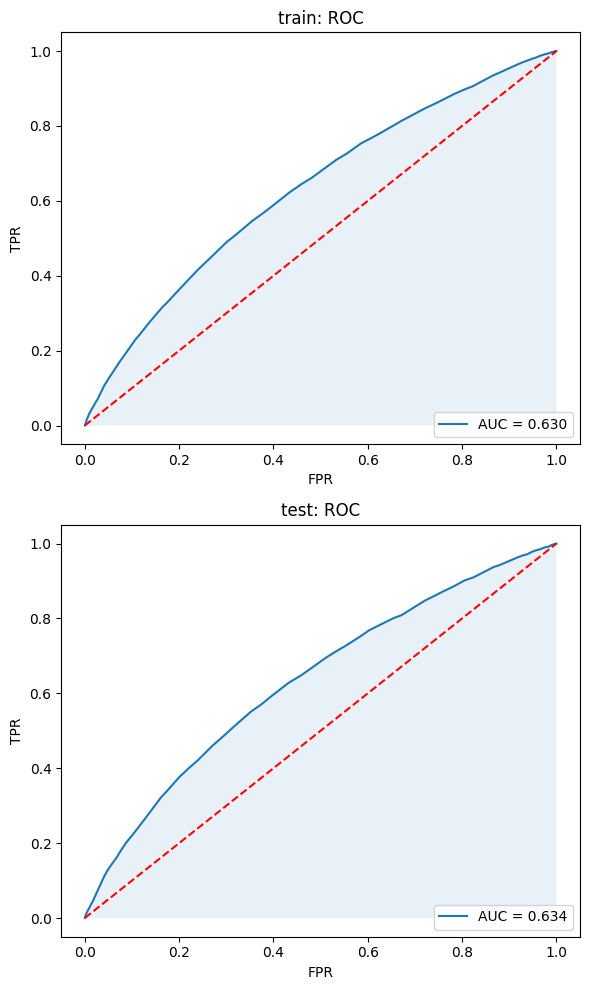

In [18]:
train_decision = -train_score
test_decision  = -test_score

# --- Compute ROC and AUC for train ---
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, train_decision)
auc_train = metrics.roc_auc_score(y_train, train_decision)

# --- Compute ROC and AUC for test ---
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, test_decision)
auc_test = metrics.roc_auc_score(y_test, test_decision)

print(f"Train AUC: {auc_train:.3f}")
print(f"Test  AUC: {auc_test:.3f}")

# --- Plot ROC curves (train + test) ---
fig, axes = plt.subplots(2, 1, figsize=(6, 10))

# Train ROC
axes[0].plot(fpr_train, tpr_train, label=f"AUC = {auc_train:.3f}")
axes[0].plot([0, 1], [0, 1], 'r--')  # random baseline
axes[0].set_title("train: ROC")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].fill_between(fpr_train, tpr_train, alpha=0.1)
axes[0].legend(loc="lower right")

# Test ROC
axes[1].plot(fpr_test, tpr_test, label=f"AUC = {auc_test:.3f}")
axes[1].plot([0, 1], [0, 1], 'r--')  # random baseline
axes[1].set_title("test: ROC")
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].fill_between(fpr_test, tpr_test, alpha=0.1)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [19]:
# combine all variable tables into one big dataframe
card_df = pd.concat(card.values(), ignore_index=True)

# show all rows (or set a big number)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

card_df

,variable,bin,points
0,basepoints,NaN,0.0
1,AMT_CREDIT_SUM_DEBT_sum,"[-inf,8000.0)",65.0
2,AMT_CREDIT_SUM_DEBT_sum,"[8000.0,44000.0)",60.0
3,AMT_CREDIT_SUM_DEBT_sum,"[44000.0,inf)",56.0
4,AMT_CREDIT,"[-inf,150000.0)",71.0
5,AMT_CREDIT,"[150000.0,300000.0)",65.0
6,AMT_CREDIT,"[300000.0,650000.0)",60.0
7,AMT_CREDIT,"[650000.0,1100000.0)",66.0
8,AMT_CREDIT,"[1100000.0,1350000.0)",70.0
9,AMT_CREDIT,"[1350000.0,inf)",78.0
